##Muskan Arora
##102015040
##ENC-2


In [51]:
import pickle
import numpy as np

In [52]:
from nltk.tokenize import word_tokenize
from functools import reduce
import nltk
nltk.download('punkt')
def parse_stories(lines):
    '''
    - Parse stories provided in the bAbI tasks format
    - A story starts from line 1 to line 15. Every 3rd line,
      there is a question &amp;amp;amp;amp;amp; answer.
    - Function extracts sub-stories within a story and
      creates tuples
    '''
    data = []
    story = []
    for line in lines:
        line = line.decode('utf-8').strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            # reset story when line ID=1 (start of new story)
            story = []
        if '\t' in line:
            # this line is tab separated Q, A &amp;amp;amp;amp;amp; support fact ID
            q, a, supporting = line.split('\t')
            # tokenize the words of question
            q = word_tokenize(q)
            # Provide all the sub-stories till this question
            substory = [x for x in story if x]
            # A story ends and is appended to global story data-set
            data.append((substory, q, a))
            story.append('')
        else:
            # this line is a sentence of story
            sent = word_tokenize(line)
            story.append(sent)
    return data

def get_stories(f):
    '''
    argument: filename
    returns list of all stories in the argument data-set file
    '''
    # read the data file and parse 10k stories
    data = parse_stories(f.readlines())
    # lambda func to flatten the list of sentences into one list
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    # creating list of tuples for each story
    data = [(flatten(story), q, answer) for story, q, answer in data]
    return data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [53]:
from keras.utils.data_utils import get_file
with open('qa1_single-supporting-fact_train.txt', 'rb') as f:
  train_data = get_stories(f)

In [54]:
with open('qa1_single-supporting-fact_test.txt', 'rb') as f:
  test_data = get_stories(f)

In [55]:
print(type(train_data))
print(type(test_data))

<class 'list'>
<class 'list'>


In [56]:
print("Length of the train data: ", len(train_data))
print("Length of the test data: ", len(test_data))

Length of the train data:  10000
Length of the test data:  1000


In [57]:
train_data[:2]

[(['Mary',
   'moved',
   'to',
   'the',
   'bathroom',
   '.',
   'John',
   'went',
   'to',
   'the',
   'hallway',
   '.'],
  ['Where', 'is', 'Mary', '?'],
  'bathroom'),
 (['Mary',
   'moved',
   'to',
   'the',
   'bathroom',
   '.',
   'John',
   'went',
   'to',
   'the',
   'hallway',
   '.',
   'Daniel',
   'went',
   'back',
   'to',
   'the',
   'hallway',
   '.',
   'Sandra',
   'moved',
   'to',
   'the',
   'garden',
   '.'],
  ['Where', 'is', 'Daniel', '?'],
  'hallway')]

In [58]:
# Train_data is a list of tuples consist of 3 parts: story, question, answer.
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'John',
  'went',
  'to',
  'the',
  'hallway',
  '.'],
 ['Where', 'is', 'Mary', '?'],
 'bathroom')

In [59]:
' '.join(train_data[0][0])

'Mary moved to the bathroom . John went to the hallway .'

In [60]:
' '.join(train_data[0][1])

'Where is Mary ?'

In [61]:
train_data[0][2]

'bathroom'

In [62]:
all_data = test_data + train_data

In [63]:
len(all_data)

11000

In [64]:
set(train_data[0][0])

{'.', 'John', 'Mary', 'bathroom', 'hallway', 'moved', 'the', 'to', 'went'}

In [65]:
# Build vocabulary from all stories and questions
vocab = set()

for story, question, answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

In [66]:
vocab.add('no')

In [67]:
vocab.add('yes')

In [68]:
vocab

{'.',
 '?',
 'Daniel',
 'John',
 'Mary',
 'Sandra',
 'Where',
 'back',
 'bathroom',
 'bedroom',
 'garden',
 'hallway',
 'is',
 'journeyed',
 'kitchen',
 'moved',
 'no',
 'office',
 'the',
 'to',
 'travelled',
 'went',
 'yes'}

In [69]:
# Add one to length of vocabulary: Keras embedding layer requires this.
vocab_len = len(vocab) + 1
print("Actual length of the vocabulary: ", vocab_len-1)

Actual length of the vocabulary:  23


In [70]:
# Length of all the stories
all_story_len = [len(data[0]) for data in all_data]

In [71]:
# Get maximum of the stories
max_story_len = max(all_story_len)

In [72]:
max_question_len = max([len(data[1]) for data in all_data])

In [73]:
print("Maximum length of the stories: ", max_story_len)
print("Maximum length of the question: ", max_question_len)

Maximum length of the stories:  68
Maximum length of the question:  4


In [74]:
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer

In [75]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)  # create a dictionary for the entire corpus

In [76]:
tokenizer.word_index

{'the': 1,
 'no': 2,
 'bathroom': 3,
 'garden': 4,
 'john': 5,
 'moved': 6,
 'where': 7,
 'went': 8,
 'mary': 9,
 'kitchen': 10,
 'sandra': 11,
 'is': 12,
 'hallway': 13,
 'travelled': 14,
 '?': 15,
 'daniel': 16,
 'back': 17,
 'journeyed': 18,
 '.': 19,
 'bedroom': 20,
 'to': 21,
 'office': 22,
 'yes': 23}

In [77]:
train_story_text = []
train_question_text = []
train_answers = []

In [78]:
for story, question, answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)
    train_answers.append(answer)

In [79]:
# Train_story_text is a list of lists of words
train_story_text[:2]

[['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'John',
  'went',
  'to',
  'the',
  'hallway',
  '.'],
 ['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'John',
  'went',
  'to',
  'the',
  'hallway',
  '.',
  'Daniel',
  'went',
  'back',
  'to',
  'the',
  'hallway',
  '.',
  'Sandra',
  'moved',
  'to',
  'the',
  'garden',
  '.']]

In [80]:
# transforms each text into a sequence of integers (word embedding)
# Vectorization in machine learning refers to the process of converting data into arrays of numerical values, known as vectors. to make code efficient.

train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [81]:
print(len(train_story_seq))
print(len(train_story_text))

10000
10000


In [82]:
train_story_text[:2]

[['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'John',
  'went',
  'to',
  'the',
  'hallway',
  '.'],
 ['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'John',
  'went',
  'to',
  'the',
  'hallway',
  '.',
  'Daniel',
  'went',
  'back',
  'to',
  'the',
  'hallway',
  '.',
  'Sandra',
  'moved',
  'to',
  'the',
  'garden',
  '.']]

In [83]:
# Word embedding result
train_story_seq[:2]

[[9, 6, 21, 1, 3, 19, 5, 8, 21, 1, 13, 19],
 [9,
  6,
  21,
  1,
  3,
  19,
  5,
  8,
  21,
  1,
  13,
  19,
  16,
  8,
  17,
  21,
  1,
  13,
  19,
  11,
  6,
  21,
  1,
  4,
  19]]

In [134]:
# Create our own list of list of word indicies with padding.
# any sequence that doesn't have the same length, you will pad your sequence to max_len, it will add 0's to it.
# in order to make all sequences in a batch fit a given standard length is to be done.
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len, max_question_len=max_question_len):
    # Stories = X
    X = []
    
    # Questions = Xq
    Xq = []
    
    # Y Correct Answer ['yes', 'no']
    Y = []
    for story, query, answer in data:
        
        # for each story
        # [23, 14, 15]
        x = [word_index[word.lower()] for word in story] #word.lower() lowers a string
        xq = [word_index[word.lower()] for word in query]
        
        y = np.zeros(len(word_index)+1)
        y[word_index[answer]] = 1
        
        X.append(x)   # X holds list of lists of word indices for stories.
        Xq.append(xq) # Xq holds list of lists for word indices for questions.
        Y.append(y) # Y holds lists of lists of (38) biniary numbers, only 1 of them is 1.
        
    return (pad_sequences(X, maxlen=max_story_len), pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [130]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

In [131]:
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [87]:
inputs_test

array([[ 0,  0,  0, ...,  1,  3, 19],
       [ 0,  0,  0, ...,  1, 20, 19],
       [ 0,  0,  0, ...,  1, 10, 19],
       ...,
       [ 0,  0,  0, ...,  1, 20, 19],
       [ 0,  0,  0, ...,  1,  3, 19],
       [ 0,  0,  0, ...,  1,  4, 19]], dtype=int32)

In [88]:
answers_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [89]:
tokenizer.word_index['yes']

23

In [90]:
tokenizer.word_index['no']

2

In [91]:
sum(answers_test)

array([  0.,   0.,   0., 149., 187.,   0.,   0.,   0.,   0.,   0., 157.,
         0.,   0., 154.,   0.,   0.,   0.,   0.,   0.,   0., 171.,   0.,
       182.,   0.])

In [92]:
#Architecture of Model
from keras.models import Sequential, Model
from keras.layers import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate, LSTM

In [93]:
# placeholders for inputs
# Recall we technically have two inputs, stories and questions. So we need to use placeholders. Input() is used to instantiate a Keras tensor
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))
question

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'input_2')>

In [94]:
# vocab_len
vocab_size = len(vocab) + 1

In [95]:
# INPUT ENCODER M
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size, output_dim=64))
input_encoder_m.add(Dropout(0.3))

# OUTPUT
# (samples, story_maxlen, embedding_dim)

In [96]:
# INPUT ENCODER C
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size, output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))

# OUTPUT
# (samples, story_maxlen, max_question_len)

In [97]:
# question encoder
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_question_len))
question_encoder.add(Dropout(0.3))

# OUTPUT
# (samples, query_maxlen, embedding_dim)

In [98]:
# ENCODED <---- ENCODER(INPUT)
# # encode input sequence and questions (which are indices) to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

# input_encoded_m: (batch_size, story_maxlen, embedding_dim)
# input_encoded_c: (batch_size, story_maxlen, query_maxlen)
# question_encoded: (batch_size, query_maxlen, embedding_dim)

In [99]:
print(input_encoded_m.shape)
print(question_encoded.shape)

(None, 68, 64)
(None, 4, 64)


In [100]:
match = dot([input_encoded_m, question_encoded], axes=(2,2)) # why axes is (2,2) ==> dot product along the embedding dim (64 numbers dot 64 numbers)
match = Activation('softmax')(match)

# NOTE: match after dot: (batch_size, story_maxlen, query_maxlen)
# match after Activation: (batch_size, story_maxlen, query_maxlen)

In [101]:
response = add([match, input_encoded_c]) # (samples, story_maxlen, query_maxlen)
response = Permute((2,1))(response) # (samples, query_maxlen, story_maxlen)
# Permutes the dimensions of the input according to a given pattern.
# Same as the input shape, but with the dimensions re-ordered according to the specified pattern

# response after add: (batch_size, story_maxlen, query_maxlen)
# response after Permute: (batch_size, query_maxlen, story_maxlen)

In [102]:
answer = concatenate([response, question_encoded])

# Note: answer: (batch_size, query_maxlen, story_maxlen+embedding_dim)

In [103]:
answer
# Note: answer: (batch_size, query_maxlen, story_maxlen+embedding_dim)

<KerasTensor: shape=(None, 4, 132) dtype=float32 (created by layer 'concatenate')>

In [104]:
# Reduce with RNN (LSTM) : does its work
answer = LSTM(32)(answer) #(samples, 32)

In [105]:
print(answer.shape)

(None, 32)


In [106]:
# Regularization with Dropout
answer = Dropout(0.5)(answer)

In [107]:
answer = Dense(vocab_size)(answer)

In [108]:
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

In [109]:
answer

<KerasTensor: shape=(None, 24) dtype=float32 (created by layer 'activation_1')>

In [110]:
model = Model([input_sequence, question], answer)
#creating deep models

In [111]:
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [112]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 68)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 sequential (Sequential)        (None, None, 64)     1536        ['input_1[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 4, 64)        1536        ['input_2[0][0]']                
                                                                                              

In [113]:
history = model.fit([inputs_train, queries_train], answers_train, batch_size=32, epochs=100, validation_data=([inputs_test, queries_test], answers_test))

Epoch 1/100
313/313 [==============================] - 8s 13ms/step - loss: 2.0943 - accuracy: 0.1660 - val_loss: 1.8140 - val_accuracy: 0.1490
Epoch 2/100
313/313 [==============================] - 4s 11ms/step - loss: 1.8529 - accuracy: 0.1795 - val_loss: 1.7733 - val_accuracy: 0.2300
Epoch 3/100
313/313 [==============================] - 5s 15ms/step - loss: 1.7556 - accuracy: 0.2389 - val_loss: 1.6437 - val_accuracy: 0.3060
Epoch 4/100
313/313 [==============================] - 3s 11ms/step - loss: 1.6134 - accuracy: 0.3650 - val_loss: 1.5060 - val_accuracy: 0.4580
Epoch 5/100
313/313 [==============================] - 3s 11ms/step - loss: 1.5600 - accuracy: 0.4026 - val_loss: 1.4725 - val_accuracy: 0.4580
Epoch 6/100
313/313 [==============================] - 5s 15ms/step - loss: 1.5360 - accuracy: 0.4210 - val_loss: 1.4595 - val_accuracy: 0.4540
Epoch 7/100
313/313 [==============================] - 3s 11ms/step - loss: 1.5081 - accuracy: 0.4328 - val_loss: 1.4378 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


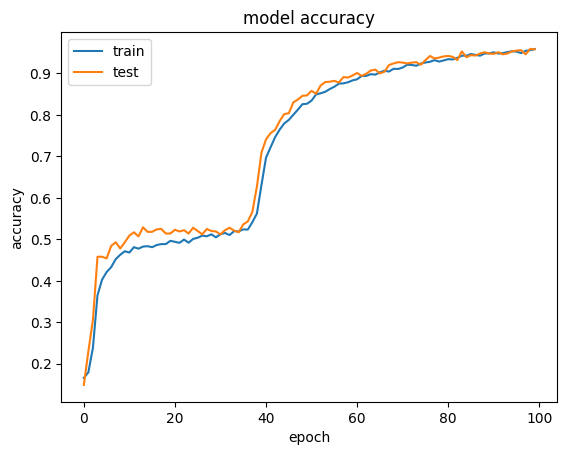

In [114]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [115]:
model.save('mybrandnewmodel.h5')

In [116]:
pred_result = model.predict(([inputs_test, queries_test]))

32/32 [==============================] - 1s 3ms/step


In [117]:
pred_result.shape

(1000, 24)

In [118]:
pred_result[0]

array([3.1504215e-15, 3.5272553e-15, 3.8099169e-15, 3.4767931e-05,
       8.1328642e-07, 2.9902442e-15, 2.5731832e-15, 2.8998366e-15,
       2.7468196e-15, 4.3525063e-15, 7.8504842e-10, 3.6281610e-15,
       2.7918642e-15, 9.9996096e-01, 2.9918186e-15, 4.1651850e-15,
       3.1772267e-15, 2.9632641e-15, 3.3961161e-15, 2.9229148e-15,
       3.3056333e-06, 2.9486276e-15, 6.5802460e-08, 3.1249868e-15],
      dtype=float32)

In [119]:
index_word = {index: word for word, index in tokenizer.word_index.items()}

In [120]:
predictions = np.argmax(pred_result, axis=1)
pred_answers = [index_word[pred] for pred in predictions]
pred_answers

['hallway',
 'bathroom',
 'kitchen',
 'hallway',
 'kitchen',
 'hallway',
 'garden',
 'hallway',
 'office',
 'office',
 'kitchen',
 'garden',
 'office',
 'bedroom',
 'bedroom',
 'kitchen',
 'garden',
 'kitchen',
 'office',
 'bathroom',
 'hallway',
 'office',
 'office',
 'hallway',
 'bedroom',
 'bedroom',
 'bedroom',
 'kitchen',
 'kitchen',
 'office',
 'hallway',
 'office',
 'kitchen',
 'kitchen',
 'bathroom',
 'office',
 'bathroom',
 'garden',
 'kitchen',
 'bedroom',
 'bathroom',
 'garden',
 'hallway',
 'hallway',
 'garden',
 'kitchen',
 'hallway',
 'bathroom',
 'office',
 'bedroom',
 'bedroom',
 'office',
 'garden',
 'garden',
 'garden',
 'bedroom',
 'kitchen',
 'hallway',
 'bedroom',
 'hallway',
 'hallway',
 'office',
 'bathroom',
 'garden',
 'garden',
 'kitchen',
 'kitchen',
 'bathroom',
 'office',
 'office',
 'garden',
 'hallway',
 'garden',
 'bedroom',
 'bathroom',
 'kitchen',
 'kitchen',
 'kitchen',
 'hallway',
 'office',
 'garden',
 'bathroom',
 'bedroom',
 'kitchen',
 'office',
